## Run the fire expansion and merging algorithm

`Fire_Forward` is responsible for reading in the preprocessed data created in the `Ingest` notebook

In [46]:
import pandas as pd

import FireMain, FireTime, FireObj, FireConsts, FireVector
from utils import timed

region = ["CONUS",]
tst = [2023, 8, 28, 'AM']
ted = [2023, 9, 6, 'AM']

In [2]:
allfires, allpixels = FireMain.Fire_Forward(tst=tst, ted=ted, restart=False, region=region)

2024-01-26 15:53:10,846 - FireLog - INFO - func:read_preprocessed took: 5.96 ms
2024-01-26 15:53:10,851 - FireLog - INFO - func:read_preprocessed took: 4.17 ms
2024-01-26 15:53:10,857 - FireLog - INFO - func:read_preprocessed took: 5.03 ms
2024-01-26 15:53:10,861 - FireLog - INFO - func:read_preprocessed took: 4.11 ms
2024-01-26 15:53:10,866 - FireLog - INFO - func:read_preprocessed took: 4.40 ms
2024-01-26 15:53:10,871 - FireLog - INFO - func:read_preprocessed took: 4.37 ms
2024-01-26 15:53:10,876 - FireLog - INFO - func:read_preprocessed took: 4.90 ms
2024-01-26 15:53:10,880 - FireLog - INFO - func:read_preprocessed took: 3.16 ms
2024-01-26 15:53:10,884 - FireLog - INFO - func:read_preprocessed took: 3.44 ms
2024-01-26 15:53:10,886 - FireLog - INFO - func:read_preprocessed took: 2.00 ms
2024-01-26 15:53:10,890 - FireLog - INFO - func:read_preprocessed took: 3.41 ms
2024-01-26 15:53:10,892 - FireLog - INFO - func:read_preprocessed took: 1.85 ms
2024-01-26 15:53:10,896 - FireLog - INFO

## Serialize to disk

- allpixels -> one file for each t
- fire attributes -> one file to hold all the metadata

In [3]:
%%time
for t in FireTime.t_generator(tst, ted):
    pixels = allpixels[allpixels["t"] == FireTime.t2dt(t)]
    filepath = f"out/{region[0]}/{t[0]}{t[1]:02}{t[2]:02}_{t[3]}.txt"
    pixels.to_csv(filepath)

CPU times: user 136 ms, sys: 11.9 ms, total: 148 ms
Wall time: 148 ms


In [4]:
%%time
fires_df = pd.DataFrame.from_dict(
    {
        f.fireID: {
            "t_st": FireTime.t2dt(f.t_st), 
            "t_ed": FireTime.t2dt(f.t_ed), 
            "ftype": f.ftype
        } for f in allfires.fires.values()
    }, orient="index"
)
fires_df.index.name = "fireID"
fires_df.to_csv(f"out/{region[0]}/fire_metadata.txt")

CPU times: user 42.1 ms, sys: 10 µs, total: 42.1 ms
Wall time: 40.9 ms


## Read from disk

In [41]:
%%time
allpixels = pd.concat([
    pd.read_csv(f"out/{region[0]}/{t[0]}{t[1]:02}{t[2]:02}_{t[3]}.txt", index_col="uuid", parse_dates=["t"])
    for t in FireTime.t_generator(tst, ted)
])

CPU times: user 76.8 ms, sys: 12 ms, total: 88.7 ms
Wall time: 89.4 ms


In [6]:
%%time
fires_df = pd.read_csv(f"out/{region[0]}/fire_metadata.txt", index_col="fireID", parse_dates=["t_st", "t_ed"])

CPU times: user 10.7 ms, sys: 4.08 ms, total: 14.8 ms
Wall time: 13.7 ms


## Rehydrate a particular allfires

In [58]:
@timed
def rehydrate_allfires(t, allpixels, fires_df, activeonly):
    has_started = fires_df.t_st <= FireTime.t2dt(t)
    if activeonly:
        # this does not currently include sleeper fires
        is_active = (FireTime.t2dt(t) - fires_df.t_ed).dt.days <= FireConsts.maxoffdays
        fids = fires_df.index[(has_started & is_active)]
    else:
        fids = fires_df.index[has_started]
    a = FireObj.Allfires(t)
    for fid in fids:
        f = FireObj.Fire(fid, t, allpixels)
        metadata = fires_df.loc[fid]
        f.t_st = FireTime.dt2t(metadata.t_st)
        f.t_ed = FireTime.dt2t(metadata.t_ed)
        f.ftype = metadata.ftype
        if f.isactive:
            f.hull = FireVector.cal_hull(f.locs, sensor=f.sensor)
        a.fires[fid] = f
        if f.isignition:
            a.fids_new.append(fid)
        else:
            a.fids_expanded.append(fid)
    return a

For instance let's rehydrate just the last allfires object. 

This should be equivalent to the allfires object that we generated at the top of this notebook.

In [59]:
a = rehydrate_allfires(ted, allpixels, fires_df, activeonly=False)
a

2024-01-26 16:52:56,547 - FireLog - INFO - func:rehydrate_allfires took: 3.40 sec


<Allfires at t=[2023, 9, 6, 'AM'] with n_fires=4342>

217

38.86283884403084

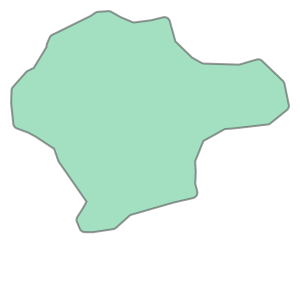

305

159.38362074239555

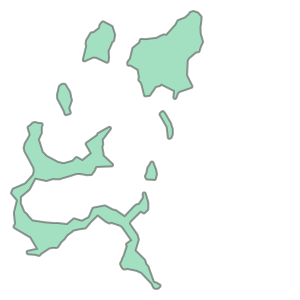

308

38.1056976942764

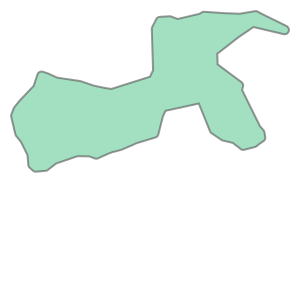

In [94]:
for fid in allfires.fids_active:
    if allfires.fires[fid].farea > 35:
        display(fid, a.fires[fid].farea, a.fires[fid].hull)

What does it look like to rehydrate the object for all timesteps?

In [27]:
%%time
for t in FireTime.t_generator(tst, ted):
    a = rehydrate_allfires(t, allpixels, fires_df, activeonly=False)

2024-01-26 16:03:11,499 - FireLog - INFO - func:rehydrate_allfires took: 36.18 ms
2024-01-26 16:03:11,546 - FireLog - INFO - func:rehydrate_allfires took: 45.90 ms
2024-01-26 16:03:11,605 - FireLog - INFO - func:rehydrate_allfires took: 58.53 ms
2024-01-26 16:03:11,676 - FireLog - INFO - func:rehydrate_allfires took: 70.20 ms
2024-01-26 16:03:11,759 - FireLog - INFO - func:rehydrate_allfires took: 81.00 ms
2024-01-26 16:03:11,853 - FireLog - INFO - func:rehydrate_allfires took: 93.10 ms
2024-01-26 16:03:11,958 - FireLog - INFO - func:rehydrate_allfires took: 103.71 ms
2024-01-26 16:03:12,073 - FireLog - INFO - func:rehydrate_allfires took: 114.42 ms
2024-01-26 16:03:12,198 - FireLog - INFO - func:rehydrate_allfires took: 123.18 ms
2024-01-26 16:03:12,333 - FireLog - INFO - func:rehydrate_allfires took: 134.00 ms
2024-01-26 16:03:12,479 - FireLog - INFO - func:rehydrate_allfires took: 144.04 ms
2024-01-26 16:03:12,633 - FireLog - INFO - func:rehydrate_allfires took: 152.77 ms
2024-01-26

CPU times: user 2.63 s, sys: 0 ns, total: 2.63 s
Wall time: 2.63 s


In [25]:
%%time
for t in FireTime.t_generator(tst, ted):
    a = rehydrate_allfires(t, allpixels, fires_df, activeonly=True)

2024-01-26 16:02:35,829 - FireLog - INFO - func:rehydrate_allfires took: 33.23 ms
2024-01-26 16:02:35,877 - FireLog - INFO - func:rehydrate_allfires took: 46.14 ms
2024-01-26 16:02:35,934 - FireLog - INFO - func:rehydrate_allfires took: 56.36 ms
2024-01-26 16:02:36,006 - FireLog - INFO - func:rehydrate_allfires took: 71.10 ms
2024-01-26 16:02:36,087 - FireLog - INFO - func:rehydrate_allfires took: 80.70 ms
2024-01-26 16:02:36,185 - FireLog - INFO - func:rehydrate_allfires took: 96.73 ms
2024-01-26 16:02:36,286 - FireLog - INFO - func:rehydrate_allfires took: 99.69 ms
2024-01-26 16:02:36,402 - FireLog - INFO - func:rehydrate_allfires took: 114.92 ms
2024-01-26 16:02:36,525 - FireLog - INFO - func:rehydrate_allfires took: 122.72 ms
2024-01-26 16:02:36,660 - FireLog - INFO - func:rehydrate_allfires took: 133.77 ms
2024-01-26 16:02:36,804 - FireLog - INFO - func:rehydrate_allfires took: 142.17 ms
2024-01-26 16:02:36,957 - FireLog - INFO - func:rehydrate_allfires took: 151.84 ms
2024-01-26 

CPU times: user 2.32 s, sys: 7.99 ms, total: 2.33 s
Wall time: 2.34 s


## Experiments with not using a metadata file

Notice that we don't have `ftype` (or hull) in the fire objects in this version.

In [30]:
@timed
def rehydrate_allfires_no_metadata(t, allpixels, activeonly):
    has_started = allpixels["t"] <= FireTime.t2dt(t)
    if activeonly:
        is_active = (FireTime.t2dt(t) - allpixels["t"]).dt.days <= FireConsts.maxoffdays
        fids = allpixels[has_started & is_active].fid.unique()
    else:
        fids = allpixels[has_started].fid.unique()
    a = FireObj.Allfires(t)
    for fid in fids:
        f = FireObj.Fire(fid, t, allpixels)
        f.t_st = FireTime.dt2t(f.pixels.t.min())
        f.t_ed = FireTime.dt2t(f.pixels.t.max())
        a.fires[fid] = f
        if f.isignition:
            a.fids_new.append(fid)
        else:
            a.fids_expanded.append(fid)
    return a

In [32]:
%%time
for t in FireTime.t_generator(tst, ted):
    rehydrate_allfires_no_metadata(t, allpixels, activeonly=False)

2024-01-26 16:04:44,681 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 280.28 ms
2024-01-26 16:04:45,234 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 551.73 ms
2024-01-26 16:04:45,932 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 697.67 ms
2024-01-26 16:04:46,824 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 891.16 ms
2024-01-26 16:04:47,826 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.00 sec
2024-01-26 16:04:49,068 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.24 sec
2024-01-26 16:04:50,357 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.29 sec
2024-01-26 16:04:51,851 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.49 sec
2024-01-26 16:04:53,467 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.62 sec
2024-01-26 16:04:55,220 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.75 sec
2024-01-26 16:04:57,096 - FireLog - INFO - func:rehydrat

CPU times: user 32.3 s, sys: 12.1 ms, total: 32.3 s
Wall time: 32.4 s


In [31]:
%%time
for t in FireTime.t_generator(tst, ted):
    rehydrate_allfires_no_metadata(t, allpixels, activeonly=True)

2024-01-26 16:04:13,761 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 289.11 ms
2024-01-26 16:04:14,304 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 542.67 ms
2024-01-26 16:04:14,995 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 689.73 ms
2024-01-26 16:04:15,875 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 879.25 ms
2024-01-26 16:04:16,860 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 983.34 ms
2024-01-26 16:04:18,032 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.17 sec
2024-01-26 16:04:19,308 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.27 sec
2024-01-26 16:04:20,790 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.48 sec
2024-01-26 16:04:22,388 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.60 sec
2024-01-26 16:04:24,135 - FireLog - INFO - func:rehydrate_allfires_no_metadata took: 1.75 sec
2024-01-26 16:04:25,986 - FireLog - INFO - func:rehydra

CPU times: user 28.4 s, sys: 7.98 ms, total: 28.4 s
Wall time: 28.4 s
